In [163]:
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
# open the a water year data and start exploring
year = 2019
ds = xr.open_dataset(f'../data/02_processed/AR_Events/lpt_systems_AR_{year-1}050100_{year}043018.nc')

# filter the centroid_lon_end to be between 225 and 245 and the centroid_lat_end to be between 40 and 55
ds_filter_01 = ds.where((ds.centroid_lon_end > 235) & 
              (ds.centroid_lat_end > 45) & 
              (ds.centroid_lat_end < 52), drop=True)

In [102]:
print(f'Total number of events in {year}: ', ds_filter_01.nlpt.size)
event_list = []
cols_to_exclude = ['lptid', 'nlpt', 'num_objects', 'max_filtered_running_field', 'max_inst_field', 
                   'min_filtered_running_field','min_filtered_running_field','amean_inst_field',
                   'amean_running_field', 'amean_filtered_running_field', 'min_inst_field',
                   'max_lon_stitched', 'max_lat_stitched', 'min_lon_stitched',
                   'min_lat_stitched', 'lpt_begin_index', 'lpt_end_index',
                   'lptid_stitched','nobj_stitched',]
for i in range(ds_filter_01.nlpt.size):
    lpt_begin_index = ds_filter_01.lpt_begin_index.values.astype(int)
    lpt_end_index = ds_filter_01.lpt_end_index.values.astype(int)
    # filter to a specific event
    tmp_ds = ds_filter_01.isel(nlpt=i, nstitch=slice(lpt_begin_index[i],lpt_end_index[i])).drop_dims('nobj')
    
    event_list.append(tmp_ds.where(tmp_ds.max_running_field==tmp_ds.max_running_field.max(), drop=True).to_pandas().drop(cols_to_exclude, axis=1))

Total number of events in 2019:  20


In [99]:
# Concatenate all the events into one dataframe
event_df = pd.concat(event_list, axis=0).reset_index(drop=True)

<Axes: >

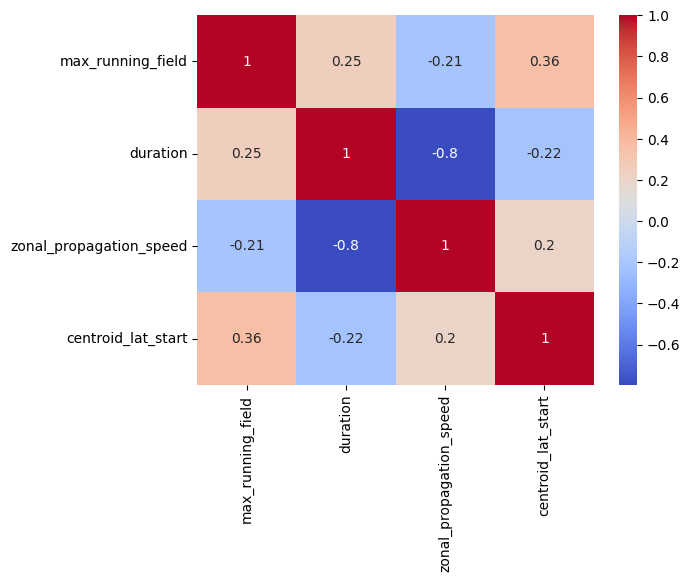

In [100]:
# Use seaborn to create a heatmap of the data to look for correlations between variables
# first, choose a few variables to compare
cols_to_compare = ['max_running_field', 'duration', 'zonal_propagation_speed', 'centroid_lat_start']
sns.heatmap(event_df[cols_to_compare].corr(), annot=True, cmap='coolwarm')


Okay, we have a way of looking at this data. Now lets make a combined dataset over these years to classify the ARs

In [103]:
years = [2015, 2016, 2017, 2018, 2019]
event_list = []
for year in years:
    ds = xr.open_dataset(f'../data/02_processed/AR_Events/lpt_systems_AR_{year-1}050100_{year}043018.nc')

    # filter the centroid_lon_end to be between 225 and 245 and the centroid_lat_end to be between 40 and 55
    ds_filter_01 = ds.where((ds.centroid_lon_end > 235) & 
                (ds.centroid_lat_end > 45) & 
                (ds.centroid_lat_end < 52), drop=True)

    for i in range(ds_filter_01.nlpt.size):
        lpt_begin_index = ds_filter_01.lpt_begin_index.values.astype(int)
        lpt_end_index = ds_filter_01.lpt_end_index.values.astype(int)
        # filter to a specific event
        tmp_ds = ds_filter_01.isel(nlpt=i, nstitch=slice(lpt_begin_index[i],lpt_end_index[i])).drop_dims('nobj')
        
        event_list.append(tmp_ds.where(tmp_ds.max_running_field==tmp_ds.max_running_field.max(), drop=True).to_pandas().drop(cols_to_exclude, axis=1))

<Axes: >

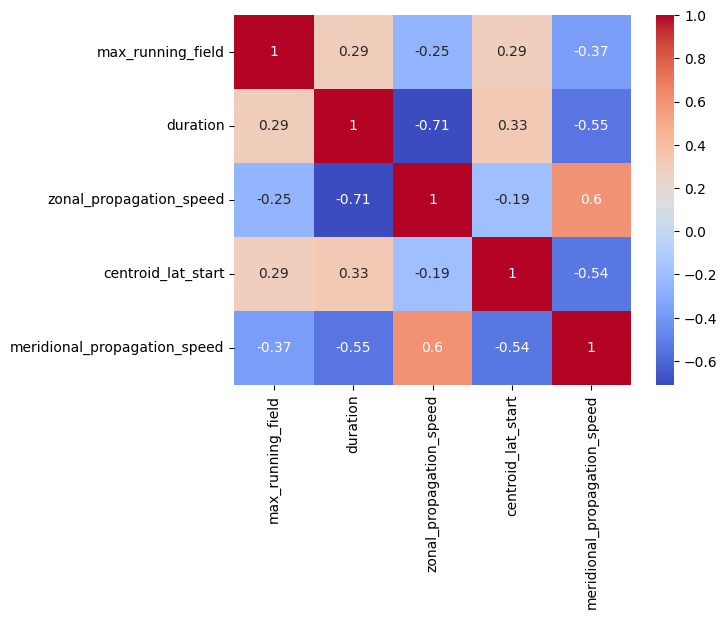

In [112]:
# Concatenate all the events into one dataframe
event_df = pd.concat(event_list, axis=0).reset_index(drop=True)
# convert duration to hours as save as an integer
event_df['duration'] =event_df['duration'].dt.days * 24
# Use seaborn to create a heatmap of the data to look for correlations between variables
# first, choose a few variables to compare
cols_to_compare = ['max_running_field', 'duration', 'zonal_propagation_speed', 'centroid_lat_start', 'meridional_propagation_speed']
sns.heatmap(event_df[cols_to_compare].corr(), annot=True, cmap='coolwarm')


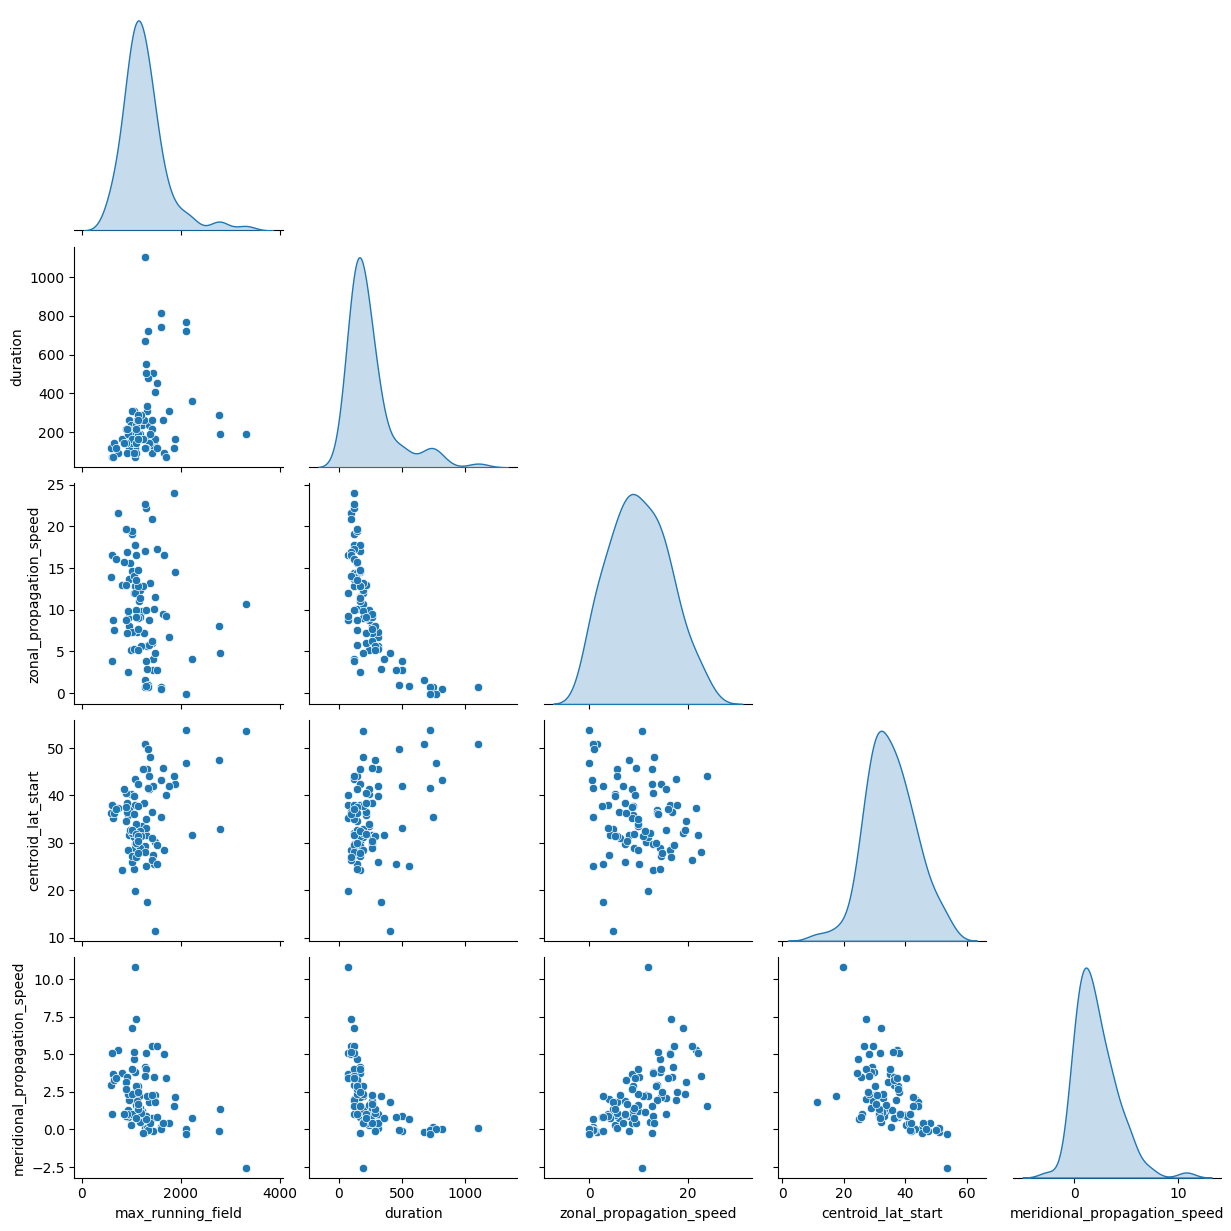

In [116]:
# create a correllogram to look for correlations between variables
sns.pairplot(event_df[cols_to_compare], diag_kind='kde', corner=True)

### Working with ERA-Interim-AR-Classification data
This data was taken from a paper repository for [this publication]([https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022JD037180).

In [86]:
ds = xr.open_dataset(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale.nc')
ds_filter_01 = ds.where((ds.lon > 235) & 
                        (ds.lon < 240) &
                        (ds.lat > 45) & 
                        (ds.lat < 52), drop=True)

In [101]:
# drop nans for time, but not all cells need to have data
ds_filter_02 = ds_filter_01.scale.squeeze().dropna(dim='time', how='all')
# filter to the years since water year 2015
ds_filter_03 = ds_filter_02.where((ds_filter_02.time.dt.year > 2014) &
                                  (ds_filter_02>0), drop=True)
# take the zonal and meridional median values
# this essentially will take the median value within the grid cells we defined as 
ds_filter_04 = ds_filter_03.median(dim='lon').median(dim='lat')
# conert to integer values and drop values less than 1
ds_filter_05 = ds_filter_04.astype(int)

In [142]:
# convert to a dataframe
df = ds_filter_05.to_dataframe()
# add a column for the date
df['date'] = df.index.date
# add a column as time difference from the previous index
df['time_diff'] = df.index.to_series().diff().dt.days

# iterate through the time_diff column, if the value is zero, store the same event id value, if the value is non-zero, add 1 to the event_id and store the value
event_id = 0
event_list = []
for val in df.time_diff:
    if val == 0:
        event_list.append(event_id)
    else:
        event_id += 1
        event_list.append(event_id)
# add event_id column to the dataframe
df['event_id'] = event_list


C:\Users\dlhogan\AppData\Local\Temp\ipykernel_26692\1630439015.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df.date[i] == df.date[i-1]:


Text(0.5, 1.0, 'Distribution of AR Scale for Events in the PNW between 2015 and 2019')

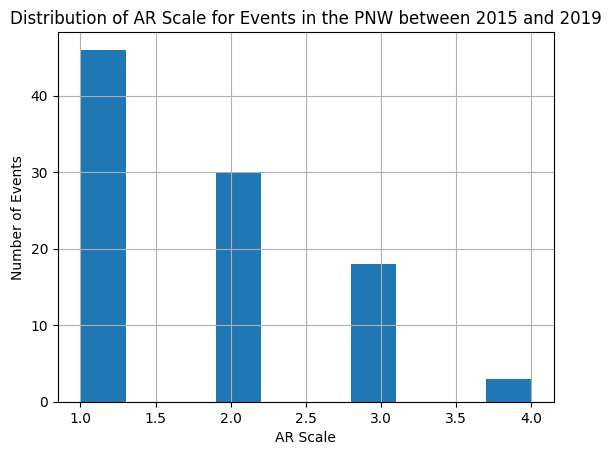

In [165]:
# groupby event ids
grouped_df = df.groupby('event_id').agg({'date': ['first', 'last'], 'time_diff': 'count', 'scale': 'max'})
grouped_df['scale'].hist()
# add x and y labels
plt.xlabel('AR Scale')
plt.ylabel('Number of Events')
# add a title
plt.title('Distribution of AR Scale for Events in the PNW between 2015 and 2019')